# Anomaly Detection

This notebook shows some basic usage of CapyMOA for Anomaly Detection tasks.

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 25/07/2024**

## 1. Unsupervised Anomaly Detection for data streams

* Recent research has been focused on unsupervised anomaly detection for data streams, as it is often difficult to obtain labeled data for training.
* Instead of using evaluation functions such as **test-then-train loop**, we will show a basic loop from scratch to evaluate the model's performance.
* Please notice that lower scores indicate higher anomaly likelihood.

In [1]:
from capymoa.datasets import ElectricityTiny
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import AnomalyDetectionEvaluator
stream = ElectricityTiny()
schema = stream.get_schema()
learner = HalfSpaceTrees(schema)
evaluator = AnomalyDetectionEvaluator(schema)
while stream.has_more_instances():
    instance = stream.next_instance()
    score = learner.score_instance(instance)
    evaluator.update(instance.y_index, score)
    learner.train(instance)
    
auc = evaluator.auc()
print(f"AUC: {auc:.2f}")

AUC: 0.54


## 2. High-level evaluation functions

* CapyMOA provides ```cumulative_evaluation_anomaly``` and ```prequential_evaluation_anomaly``` as high level functions to assess Anomaly Detectors


### 2.1 ```cumulative_evaluation_anomaly```
In this example, we use the ```cumulative_evaluation_anomaly``` function to evaluate HalfSpaceTree instead of writing **test-then-train loop** from scratch

In [6]:
from capymoa.datasets import ElectricityTiny
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import cumulative_evaluation_anomaly

stream = ElectricityTiny()
hst = HalfSpaceTrees(schema=stream.get_schema())


results = cumulative_evaluation_anomaly(stream=stream, learner=hst)

print(f'AUC: {results["cumulative"].auc():.2f}')

AUC: 0.54


### 2.2 ```prequential_evaluation_anomaly```
In this example, we use the ```prequential_evaluation_anomaly``` function with ```plot_windowed_results``` to plot AUC for HalfSpaceTrees on Electricity

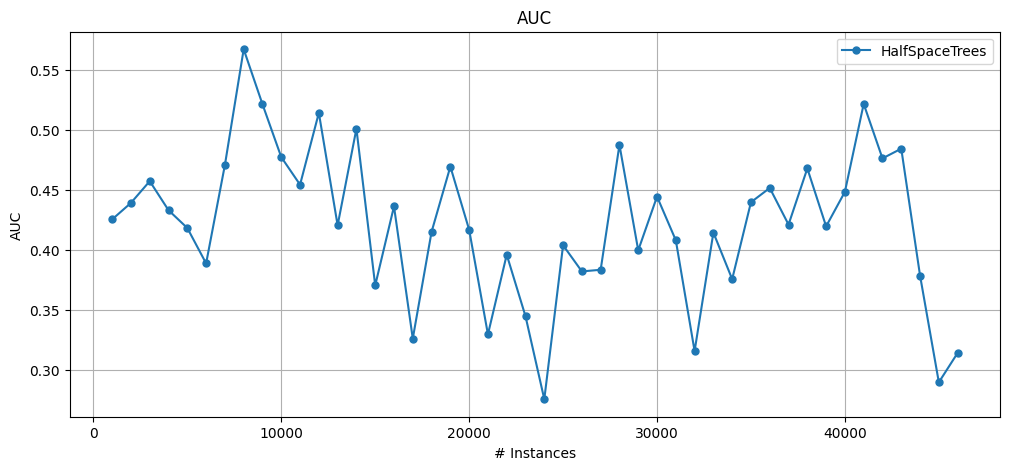

In [1]:
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.datasets import Electricity
from capymoa.anomaly import HalfSpaceTrees
from capymoa.evaluation import prequential_evaluation_anomaly

stream = Electricity()
hst = HalfSpaceTrees(schema=stream.get_schema())


results = prequential_evaluation_anomaly(stream=stream, learner=hst, window_size=1000)

results['windowed'].metrics_per_window()

plot_windowed_results(results, metric="AUC")